In [1]:
# Importing the libraries
import numpy as np
import PIL
import os
#from scipy.misc import imread, imresize
import datetime

from skimage.io import imread
from skimage.transform import rescale, resize, downscale_local_mean

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.losses import categorical_crossentropy
from keras import optimizers

import keras
from skimage import io
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import random


Using TensorFlow backend.


In [2]:
#Set the random seed so that the results don't vary drastically.
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

- loading train and validation document file

In [3]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())

------
- To run the model on 100 samples only

In [107]:
# x=np.random.choice(663, 100, replace = False)

In [5]:
# train_doc = train_doc[x]

-------

### Data Understanding (Image Preprocessing)

In [4]:
# function to plot n images using subplots
def plot_image(images, captions=None, cmap=None ):
    f, axes = plt.subplots(1, len(images), sharey=True)
    f.set_figwidth(15)
    for ax,image in zip(axes, images):
        ax.imshow(image, cmap)

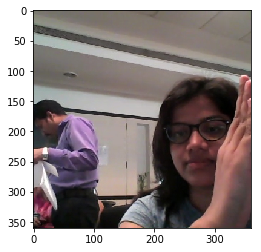

In [5]:
# Getting an image to study several processes
image = io.imread('./Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00018.png')
plt.imshow(image)

In [6]:
print(image.shape)

(360, 360, 3)


Text(0.5, 0.98, 'Different Channels of Image')

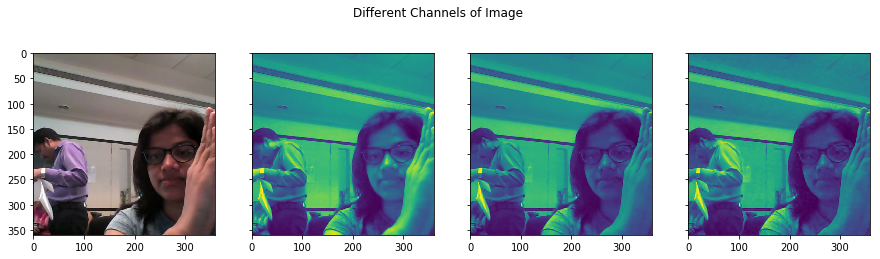

In [7]:
# plotting the original image and the RGB channels
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
f.set_figwidth(15)
ax1.imshow(image)

# RGB channels
ax2.imshow(image[:, : , 0])
ax3.imshow(image[:, : , 1])
ax4.imshow(image[:, : , 2])
f.suptitle('Different Channels of Image')

## Morphological Transformations

### Thresholding

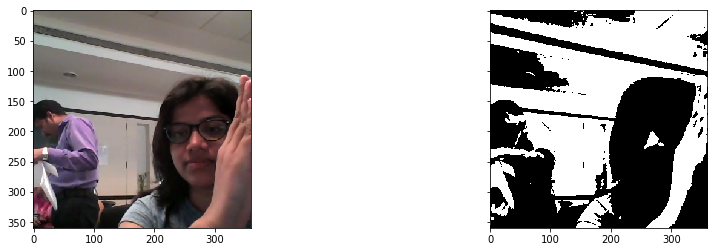

In [8]:
# bin_image will be a (240, 320) True/False array
bin_image = image[:, :, 0] > 125
plot_image([image, bin_image], cmap='gray')

### Erosion, Dilation, Opening & Closing

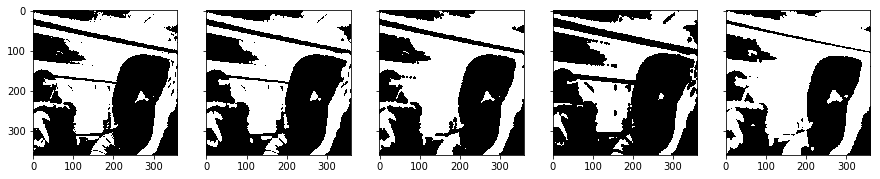

In [9]:
from skimage.morphology import binary_closing, binary_dilation, binary_erosion, binary_opening
from skimage.morphology import selem

# use a disk of radius 3
selem = selem.disk(3)

# oprning and closing
open_img = binary_opening(bin_image, selem)
close_img = binary_closing(bin_image, selem)

# erosion and dilation
eroded_img = binary_erosion(bin_image, selem)
dilated_img = binary_dilation(bin_image, selem)

plot_image([bin_image, open_img, close_img, eroded_img, dilated_img], cmap='gray')

## Normalisation 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


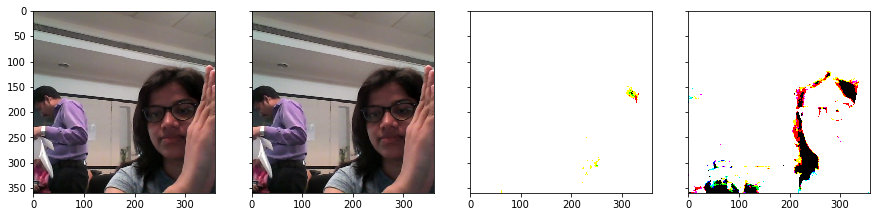

In [10]:
norm1_image = image/255
norm2_image = image - np.min(image)/np.max(image) - np.min(image)
norm3_image = image - np.percentile(image,5)/ np.percentile(image,95) - np.percentile(image,5)

plot_image([image, norm1_image, norm2_image, norm3_image], cmap='gray')

## Augmentations


1. Linear transformations
2. Affine transformations

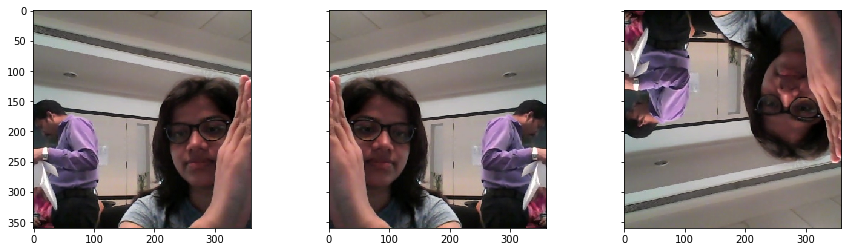

In [11]:
from skimage import transform as skitf

# flip left-right, up-down
image_flipr = np.fliplr(image)
image_flipud = np.flipud(image)

plot_image([image, image_flipr, image_flipud])

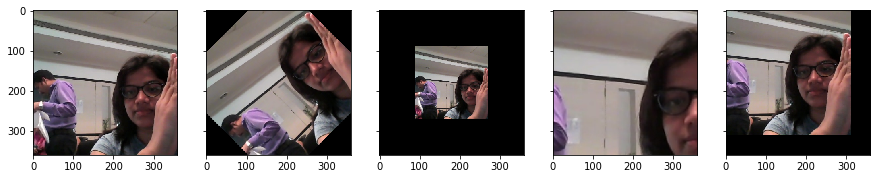

In [12]:
# specify x and y coordinates to be used for shifting (mid points)
shift_x, shift_y = image.shape[0]/2, image.shape[1]/2

# translation by certain units
matrix_to_topleft = skitf.SimilarityTransform(translation=[-shift_x, -shift_y])
matrix_to_center = skitf.SimilarityTransform(translation=[shift_x, shift_y])

# rotation
rot_transforms =  skitf.AffineTransform(rotation=np.deg2rad(45))
rot_matrix = matrix_to_topleft + rot_transforms + matrix_to_center
rot_image = skitf.warp(image, rot_matrix)

# scaling 
scale_transforms = skitf.AffineTransform(scale=(2, 2))
scale_matrix = matrix_to_topleft + scale_transforms + matrix_to_center
scale_image_zoom_out = skitf.warp(image, scale_matrix)

scale_transforms = skitf.AffineTransform(scale=(0.5, 0.5))
scale_matrix = matrix_to_topleft + scale_transforms + matrix_to_center
scale_image_zoom_in = skitf.warp(image, scale_matrix)

# translation
transaltion_transforms = skitf.AffineTransform(translation=(50, 50))
translated_image = skitf.warp(image, transaltion_transforms)


plot_image([image, rot_image, scale_image_zoom_out, scale_image_zoom_in, translated_image])

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


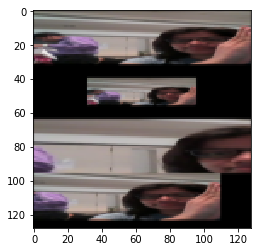

In [13]:
img_resi = np.concatenate([image/255,scale_image_zoom_out,scale_image_zoom_in,translated_image])
img_resi = resize(img_resi, (128,128), anti_aliasing=True)`
plt.imshow(img_resi)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


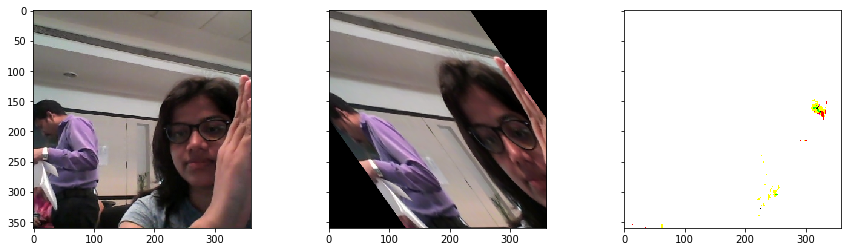

In [15]:
# shear transforms
shear_transforms = skitf.AffineTransform(shear=np.deg2rad(45))
shear_matrix = matrix_to_topleft + shear_transforms + matrix_to_center
shear_image = skitf.warp(image, shear_matrix)

bright_jitter = image*0.999 + np.zeros_like(image)*0.001

plot_image([image, shear_image, bright_jitter])

##### From the above preprocessing following remarks are obtained
1. Thresholding might improve the model performance.
2. Erosion and dilation might not be able to help much.
- Augmentation like zoom-out, zoom-in, translation might help creating more data if the model overfits.

#### Storing train and validation path and also how many number of epochs and batch size to use

In [42]:
curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10 # number of epochs
print ('# epochs =', num_epochs)
batch_size = 10 # the batch size
print ('# batch size =', batch_size)

# training sequences = 663
# validation sequences = 100
# epochs = 10
# batch size = 10


## Generator

In [ ]:
img_idx = [0,5,15,20,25,29]

In [70]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29]#create a list of image numbers you want to use for a particular video
    x = len(img_idx)
    y = 128 # Height of the image
    z = 128 # width of the image to be given to the model
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size# calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    
                    
                    
                    
                    #Resizing the image.
                    image_resized = resize(image,(y,z), anti_aliasing=True)
                    
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0]-np.min(image_resized[:,:,0]))/(np.max(image_resized[:,:,0])-np.min(image_resized[:,:,0]))#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1]-np.min(image_resized[:,:,1]))/(np.max(image_resized[:,:,1])-np.min(image_resized[:,:,1]))#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2]-np.min(image_resized[:,:,2]))/(np.max(image_resized[:,:,2])-np.min(image_resized[:,:,2]))#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # code for the remaining data points which are left after full batches
        remaining_batch_size = len(folder_list)%batch_size
        remaining_batch_data = np.zeros((remaining_batch_size,x,y,z,3))
        remaining_batch_labels = np.zeros((remaining_batch_size,5))
        if remaining_batch_size!=0:
            for folder in range(remaining_batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + len(folder_list) - remaining_batch_size].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + len(folder_list) - remaining_batch_size].strip().split(';')[0]+'/'+imgs[item])
                    image_resized = resize(image,(128,128), anti_aliasing=True)
                    
                    remaining_batch_data[folder,idx,:,:,0] = (image_resized[:,:,0]-np.min(image_resized[:,:,0]))/(np.max(image_resized[:,:,0])-np.min(image_resized[:,:,0]))#normalise and feed in the image
                    remaining_batch_data[folder,idx,:,:,1] = (image_resized[:,:,1]-np.min(image_resized[:,:,1]))/(np.max(image_resized[:,:,1])-np.min(image_resized[:,:,1]))#normalise and feed in the image
                    remaining_batch_data[folder,idx,:,:,2] = (image_resized[:,:,2]-np.min(image_resized[:,:,2]))/(np.max(image_resized[:,:,2])-np.min(image_resized[:,:,2]))#normalise and feed in the image
                    
                remaining_batch_labels[folder, int(t[folder + len(folder_list) - remaining_batch_size].strip().split(';')[2])] = 1
            yield remaining_batch_data, remaining_batch_labels 



            


## Model Building

In [36]:
# model = Sequential()

# model.add(Conv3D(16, kernel_size=(3,3,3), activation='relu', input_shape=(30,128,128,3)))
# model.add(Conv3D(32, kernel_size=(3,3,3), 
#                  activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(Dropout(0.8))

# # flatten and put a fully connected layer
# model.add(Flatten())
# model.add(Dense(128, activation='relu')) # fully connected
# model.add(Dropout(0.8))
# # softmax layer
# model.add(Dense(5, activation='softmax'))

# # model summary
# model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_7 (Conv3D)            (None, 28, 126, 126, 16)  1312      
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 26, 124, 124, 32)  13856     
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 13, 62, 62, 32)    0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 13, 62, 62, 32)    0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1599104)           0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               204685440 
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
__________

###### Compilation

In [37]:
# optimiser = 'sgd'#write your optimizer
# model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_7 (Conv3D)            (None, 28, 126, 126, 16)  1312      
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 26, 124, 124, 32)  13856     
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 13, 62, 62, 32)    0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 13, 62, 62, 32)    0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1599104)           0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               204685440 
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
__________

#### train_generator and the val_generator

In [38]:
# train_generator = generator('./Project_data/train', train_doc, batch_size)
# val_generator = generator('./Project_data/val', val_doc, batch_size)

In [39]:
# model_name = 'model_1' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
# if not os.path.exists(model_name):
#     os.mkdir(model_name)
        
# filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# LR = ReduceLROnPlateau(verbose = 1)# write the REducelronplateau code here
# callbacks_list = [checkpoint, LR]

##### steps_per_epoch and validation_steps

In [40]:
# if (num_train_sequences%batch_size) == 0:
#     steps_per_epoch = int(num_train_sequences/batch_size)
# else:
#     steps_per_epoch = (num_train_sequences//batch_size) + 1

# if (num_val_sequences%batch_size) == 0:
#     validation_steps = int(num_val_sequences/batch_size)
# else:
#     validation_steps = (num_val_sequences//batch_size) + 1

- Let us now fit the model.

In [37]:
# model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1, 
#                     callbacks=callbacks_list, validation_data=val_generator, 
#                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size =Source path =  ./Project_data/train ; batch size = 10
 Epoch 1/10
10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


10/10 [==============================] - 19s 2s/step - loss: 2.0383 - categorical_accuracy: 0.2100 - val_loss: 1.6098 - val_categorical_accuracy: 0.1800

Epoch 00001: saving model to model_7_2020-05-0905_42_12.600201/model-00001-2.03831-0.21000-1.60982-0.18000.h5
Epoch 2/10
10/10 [==============================] - 16s 2s/step - loss: 1.5998 - categorical_accuracy: 0.2700 - val_loss: 1.6067 - val_categorical_accuracy: 0.1800

Epoch 00002: saving model to model_7_2020-05-0905_42_12.600201/model-00002-1.59982-0.27000-1.60670-0.18000.h5
Epoch 3/10
10/10 [==============================] - 17s 2s/step - loss: 1.6023 - categorical_accuracy: 0.2100 - val_loss: 1.5973 - val_categorical_accuracy: 0.1400

Epoch 00003: saving model to model_7_2020-05-0905_42_12.600201/model-00003-1.60233-0.21000-1.59727-0.14000.h5
Epoch 4/10
10/10 [==============================] - 18s 2s/step - loss: 1.5500 - categorical_accuracy: 0.3100 - val_loss: 1.6349 - val_categorical_accuracy: 0.1900

Epoch 00004: saving m

- Model is not learning much. Also point noticed was that if we increase the feature maps model is performing bad. So will initialise with less features and than increase them slowly.
- Another point is that of including BatchNormalization and Dropout into the model to optimise the learning.

# Model 2
- In this model we increased one layer and also added one more layer to extract more abstract features.
- Decreased the feature maps

In [10]:
# from keras.models import Sequential, Model
# from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
# from keras.layers.convolutional import Conv3D, MaxPooling3D
# from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
# from keras.losses import categorical_crossentropy
# from keras import optimizers


# # Model
# model = Sequential()

# model.add(Conv3D(8, kernel_size=(1,3,3), input_shape=(30,128,128,3),padding='same')) # keeping kernel size (1,3,3) as no. of frames are less
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPooling3D(pool_size=(2,2,2)))

# model.add(Conv3D(16, kernel_size=(1,3,3), padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPooling3D(pool_size=(2,2,2)))

# model.add(Conv3D(32, kernel_size=(1,3,3), padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPooling3D(pool_size=(2,2,2)))

# model.add(Conv3D(64, kernel_size=(1,3,3), padding='same'))
# model.add(Activation('relu'))
# model.add(Dropout(0.25))
# model.add(MaxPooling3D(pool_size=(2,2,2)))

# #Flatten Layers
# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))

# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))

# #softmax layer
# model.add(Dense(5, activation='softmax'))

# print(model.summary())

- Compilation

In [11]:
# optimiser = 'adam'#write your optimizer
# model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 20, 128, 128, 8)   224       
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 128, 128, 8)   32        
_________________________________________________________________
activation_1 (Activation)    (None, 20, 128, 128, 8)   0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 10, 64, 64, 8)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 10, 64, 64, 16)    1168      
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 64, 64, 16)    64        
_________________________________________________________________
activation_2 (Activation)    (None, 10, 64, 64, 16)    0         
__________

- Data Generation

In [12]:
# train_generator = generator('./Project_data/train', train_doc, batch_size)
# val_generator = generator('./Project_data/val', val_doc, batch_size)

- Creating a folder to store the model

In [13]:
# model_name = 'model_2' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
# if not os.path.exists(model_name):
#     os.mkdir(model_name)
        
# filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# LR = ReduceLROnPlateau(verbose = 1)# write the REducelronplateau code here
# callbacks_list = [checkpoint, LR]

In [14]:
# if (num_train_sequences%batch_size) == 0:
#     steps_per_epoch = int(num_train_sequences/batch_size)
# else:
#     steps_per_epoch = (num_train_sequences//batch_size) + 1

# if (num_val_sequences%batch_size) == 0:
#     validation_steps = int(num_val_sequences/batch_size)
# else:
#     validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model.

In [15]:
# model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
#                     callbacks=callbacks_list, validation_data=val_generator, 
#                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size = 10
Source path =  ./Project_data/train ; batch size = 10
Epoch 1/10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


10/10 [==============================] - 30s 3s/step - loss: 4.9258 - categorical_accuracy: 0.1600 - val_loss: 1.5928 - val_categorical_accuracy: 0.1900

Epoch 00001: saving model to model_8_2020-05-0906_22_37.582990/model-00001-4.92576-0.16000-1.59275-0.19000.h5
Epoch 2/10
10/10 [==============================] - 29s 3s/step - loss: 1.6659 - categorical_accuracy: 0.3400 - val_loss: 1.5732 - val_categorical_accuracy: 0.2100

Epoch 00002: saving model to model_8_2020-05-0906_22_37.582990/model-00002-1.66587-0.34000-1.57317-0.21000.h5
Epoch 3/10
10/10 [==============================] - 28s 3s/step - loss: 1.5347 - categorical_accuracy: 0.2700 - val_loss: 1.5586 - val_categorical_accuracy: 0.3200

Epoch 00003: saving model to model_8_2020-05-0906_22_37.582990/model-00003-1.53467-0.27000-1.55858-0.32000.h5
Epoch 4/10
10/10 [==============================] - 28s 3s/step - loss: 1.3835 - categorical_accuracy: 0.4700 - val_loss: 1.4685 - val_categorical_accuracy: 0.3900

Epoch 00004: saving m

## CNN-RNN Model

In [22]:
# model = Sequential()

# model.add(TimeDistributed(Conv2D(16, (7, 7), strides=(2, 2),activation='relu', padding='same'), input_shape=(30,128,128,3)))
# model.add(TimeDistributed(Conv2D(16, (3,3),kernel_initializer="he_normal", activation='relu')))
# model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

# model.add(TimeDistributed(Conv2D(32, (3,3),padding='same', activation='relu')))
# model.add(TimeDistributed(Conv2D(32, (3,3),padding='same', activation='relu')))
# model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

# model.add(TimeDistributed(Conv2D(64, (3,3),padding='same', activation='relu')))
# model.add(TimeDistributed(Conv2D(64, (3,3),padding='same', activation='relu')))
# model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

# model.add(TimeDistributed(Conv2D(128, (3,3),padding='same', activation='relu')))
# model.add(TimeDistributed(Conv2D(128, (3,3),padding='same', activation='relu')))
# model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

# model.add(TimeDistributed(Conv2D(256, (3,3),padding='same', activation='relu')))
# model.add(TimeDistributed(Conv2D(256, (3,3),padding='same', activation='relu')))
# model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

# model.add(TimeDistributed(Flatten()))

# model.add(Dropout(0.5))
# model.add(LSTM(128, return_sequences=False, dropout=0.5))
# model.add(Dense(5, activation='softmax'))

- compilation

In [24]:
# optimiser = 'adam'#write your optimizer
# model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_19 (TimeDis (None, 20, 64, 64, 32)    4736      
_________________________________________________________________
time_distributed_20 (TimeDis (None, 20, 62, 62, 32)    9248      
_________________________________________________________________
time_distributed_21 (TimeDis (None, 20, 31, 31, 32)    0         
_________________________________________________________________
time_distributed_22 (TimeDis (None, 20, 31, 31, 64)    18496     
_________________________________________________________________
time_distributed_23 (TimeDis (None, 20, 31, 31, 64)    36928     
_________________________________________________________________
time_distributed_24 (TimeDis (None, 20, 15, 15, 64)    0         
_________________________________________________________________
time_distributed_25 (TimeDis (None, 20, 15, 15, 128)   73856     
__________

In [25]:
# train_generator = generator('./Project_data/train', train_doc, batch_size)
# val_generator = generator('./Project_data/val', val_doc, batch_size)

In [27]:
# model_name = 'model_9' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
# if not os.path.exists(model_name):
#     os.mkdir(model_name)
        
# filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# LR = ReduceLROnPlateau(verbose = 1)# write the REducelronplateau code here
# callbacks_list = [checkpoint, LR]

In [28]:
# if (num_train_sequences%batch_size) == 0:
#     steps_per_epoch = int(num_train_sequences/batch_size)
# else:
#     steps_per_epoch = (num_train_sequences//batch_size) + 1

# if (num_val_sequences%batch_size) == 0:
#     validation_steps = int(num_val_sequences/batch_size)
# else:
#     validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model.

In [29]:
# model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
#                     callbacks=callbacks_list, validation_data=val_generator, 
#                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = Source path =  ./Project_data/val ; batch size = 10
Epoch 1/10
 ./Project_data/train ; batch size = 10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


10/10 [==============================] - 31s 3s/step - loss: 1.6797 - categorical_accuracy: 0.2200 - val_loss: 1.6088 - val_categorical_accuracy: 0.1800

Epoch 00001: saving model to model_9_2020-05-0906_22_37.582990/model-00001-1.67966-0.22000-1.60877-0.18000.h5
Epoch 2/10
10/10 [==============================] - 29s 3s/step - loss: 1.6094 - categorical_accuracy: 0.1300 - val_loss: 1.6087 - val_categorical_accuracy: 0.2200

Epoch 00002: saving model to model_9_2020-05-0906_22_37.582990/model-00002-1.60940-0.13000-1.60866-0.22000.h5
Epoch 3/10
10/10 [==============================] - 28s 3s/step - loss: 1.6123 - categorical_accuracy: 0.1800 - val_loss: 1.6071 - val_categorical_accuracy: 0.2200

Epoch 00003: saving model to model_9_2020-05-0906_22_37.582990/model-00003-1.61230-0.18000-1.60709-0.22000.h5
Epoch 4/10
10/10 [==============================] - 30s 3s/step - loss: 1.6101 - categorical_accuracy: 0.2100 - val_loss: 1.6072 - val_categorical_accuracy: 0.2200

Epoch 00004: saving m

# Model on few frames from the sequence
- Here I change the frames in generator to 20 only. 

In [43]:
# train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
# val_doc = np.random.permutation(open('Project_data/val.csv').readlines())

In [51]:
# curr_dt_time = datetime.datetime.now()
# train_path = './Project_data/train'
# val_path = './Project_data/val'
# num_train_sequences = len(train_doc)
# print('# training sequences =', num_train_sequences)
# num_val_sequences = len(val_doc)
# print('# validation sequences =', num_val_sequences)
# num_epochs = 20 # number of epochs
# print ('# epochs =', num_epochs)
# batch_size = 20 # the batch size
# print ('# batch size =', batch_size)

# training sequences = 663
# validation sequences = 100
# epochs = 20
# batch size = 20


In [64]:
# from keras.models import Sequential, Model
# from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
# from keras.layers.convolutional import Conv3D, MaxPooling3D
# from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
# from keras.losses import categorical_crossentropy
# from keras import optimizers


# # Model
# model = Sequential()

# model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(20,128,128,3),padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPooling3D(pool_size=(2,2,2)))

# model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPooling3D(pool_size=(2,2,2)))

# model.add(Conv3D(32, kernel_size=(1,3,3), padding='same')) # keeping kernel size (1,3,3) as no. of xdim are less
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.25))
# model.add(MaxPooling3D(pool_size=(2,2,2)))

# model.add(Conv3D(64, kernel_size=(1,3,3), padding='same'))
# model.add(Activation('relu'))
# model.add(Dropout(0.25))
# model.add(MaxPooling3D(pool_size=(2,2,2)))

# #Flatten Layers
# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))

# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))

# #softmax layer
# model.add(Dense(5, activation='softmax'))

# print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_29 (Conv3D)           (None, 20, 128, 128, 8)   656       
_________________________________________________________________
batch_normalization_15 (Batc (None, 20, 128, 128, 8)   32        
_________________________________________________________________
activation_21 (Activation)   (None, 20, 128, 128, 8)   0         
_________________________________________________________________
max_pooling3d_25 (MaxPooling (None, 10, 64, 64, 8)     0         
_________________________________________________________________
conv3d_30 (Conv3D)           (None, 10, 64, 64, 16)    3472      
_________________________________________________________________
batch_normalization_16 (Batc (None, 10, 64, 64, 16)    64        
_________________________________________________________________
activation_22 (Activation)   (None, 10, 64, 64, 16)    0         
__________

- Compilation

In [65]:
# optimiser = 'adam'#write your optimizer
# model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_29 (Conv3D)           (None, 20, 128, 128, 8)   656       
_________________________________________________________________
batch_normalization_15 (Batc (None, 20, 128, 128, 8)   32        
_________________________________________________________________
activation_21 (Activation)   (None, 20, 128, 128, 8)   0         
_________________________________________________________________
max_pooling3d_25 (MaxPooling (None, 10, 64, 64, 8)     0         
_________________________________________________________________
conv3d_30 (Conv3D)           (None, 10, 64, 64, 16)    3472      
_________________________________________________________________
batch_normalization_16 (Batc (None, 10, 64, 64, 16)    64        
_________________________________________________________________
activation_22 (Activation)   (None, 10, 64, 64, 16)    0         
__________

- Data Generation

In [66]:
# train_generator = generator('./Project_data/train', train_doc, batch_size)
# val_generator = generator('./Project_data/val', val_doc, batch_size)

- Creating a folder to store the model

In [67]:
# model_name = 'model_final' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
# if not os.path.exists(model_name):
#     os.mkdir(model_name)
        
# filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# LR = ReduceLROnPlateau(verbose = 1)# write the REducelronplateau code here
# callbacks_list = [checkpoint, LR]

In [68]:
# if (num_train_sequences%batch_size) == 0:
#     steps_per_epoch = int(num_train_sequences/batch_size)
# else:
#     steps_per_epoch = (num_train_sequences//batch_size) + 1

# if (num_val_sequences%batch_size) == 0:
#     validation_steps = int(num_val_sequences/batch_size)
# else:
#     validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model.

In [69]:
# model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
#                     callbacks=callbacks_list, validation_data=val_generator, 
#                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size =Source path =  ./Project_data/train ; batch size = 20
Epoch 1/20
 20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


34/34 [==============================] - 130s 4s/step - loss: 2.3496 - categorical_accuracy: 0.2384 - val_loss: 1.5461 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to model_final_2020-05-0909_03_36.903596/model-00001-2.37420-0.24434-1.54607-0.23000.h5
Epoch 2/20
34/34 [==============================] - 124s 4s/step - loss: 1.4360 - categorical_accuracy: 0.3554 - val_loss: 1.3709 - val_categorical_accuracy: 0.5300

Epoch 00002: saving model to model_final_2020-05-0909_03_36.903596/model-00002-1.43401-0.35596-1.37088-0.53000.h5
Epoch 3/20
34/34 [==============================] - 126s 4s/step - loss: 1.3477 - categorical_accuracy: 0.3878 - val_loss: 1.4205 - val_categorical_accuracy: 0.4200

Epoch 00003: saving model to model_final_2020-05-0909_03_36.903596/model-00003-1.35083-0.38914-1.42047-0.42000.h5
Epoch 4/20
34/34 [==============================] - 126s 4s/step - loss: 1.2502 - categorical_accuracy: 0.4503 - val_loss: 1.3651 - val_categorical_accuracy: 0.4700

Epoch

# Final Model

In [71]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())

In [72]:
curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # number of epochs
print ('# epochs =', num_epochs)
batch_size = 20 # the batch size
print ('# batch size =', batch_size)

# training sequences = 663
# validation sequences = 100
# epochs = 20
# batch size = 20


In [73]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.losses import categorical_crossentropy
from keras import optimizers


# Model
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(30,128,128,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(1,3,3), padding='same')) # keeping kernel size (1,3,3) as no. of xdim are less
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, kernel_size=(1,3,3), padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(5, activation='softmax'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_33 (Conv3D)           (None, 30, 128, 128, 8)   656       
_________________________________________________________________
batch_normalization_18 (Batc (None, 30, 128, 128, 8)   32        
_________________________________________________________________
activation_25 (Activation)   (None, 30, 128, 128, 8)   0         
_________________________________________________________________
max_pooling3d_29 (MaxPooling (None, 15, 64, 64, 8)     0         
_________________________________________________________________
conv3d_34 (Conv3D)           (None, 15, 64, 64, 16)    3472      
_________________________________________________________________
batch_normalization_19 (Batc (None, 15, 64, 64, 16)    64        
_________________________________________________________________
activation_26 (Activation)   (None, 15, 64, 64, 16)    0         
__________

- Compilation

In [74]:
optimiser = 'adam'#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_33 (Conv3D)           (None, 30, 128, 128, 8)   656       
_________________________________________________________________
batch_normalization_18 (Batc (None, 30, 128, 128, 8)   32        
_________________________________________________________________
activation_25 (Activation)   (None, 30, 128, 128, 8)   0         
_________________________________________________________________
max_pooling3d_29 (MaxPooling (None, 15, 64, 64, 8)     0         
_________________________________________________________________
conv3d_34 (Conv3D)           (None, 15, 64, 64, 16)    3472      
_________________________________________________________________
batch_normalization_19 (Batc (None, 15, 64, 64, 16)    64        
_________________________________________________________________
activation_26 (Activation)   (None, 15, 64, 64, 16)    0         
__________

- Data Generation

In [75]:
train_generator = generator('./Project_data/train', train_doc, batch_size)
val_generator = generator('./Project_data/val', val_doc, batch_size)

- Creating a folder to store the model

In [76]:
model_name = 'model_final2' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(verbose = 1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [77]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model.

In [78]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Source path =  ./Project_data/train ; batch size = 20
./Project_data/val ; batch size = 20
Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


34/34 [==============================] - 195s 6s/step - loss: 2.2430 - categorical_accuracy: 0.2163 - val_loss: 1.4943 - val_categorical_accuracy: 0.2500

Epoch 00001: saving model to model_final2_2020-05-0909_54_33.655400/model-00001-2.25279-0.22172-1.49426-0.25000.h5
Epoch 2/20
34/34 [==============================] - 179s 5s/step - loss: 1.4976 - categorical_accuracy: 0.3267 - val_loss: 1.3745 - val_categorical_accuracy: 0.4700

Epoch 00002: saving model to model_final2_2020-05-0909_54_33.655400/model-00002-1.48639-0.33484-1.37449-0.47000.h5
Epoch 3/20
34/34 [==============================] - 197s 6s/step - loss: 1.3408 - categorical_accuracy: 0.4025 - val_loss: 1.3489 - val_categorical_accuracy: 0.5100

Epoch 00003: saving model to model_final2_2020-05-0909_54_33.655400/model-00003-1.34364-0.40422-1.34887-0.51000.h5
Epoch 4/20
34/34 [==============================] - 192s 6s/step - loss: 1.2483 - categorical_accuracy: 0.4599 - val_loss: 1.4066 - val_categorical_accuracy: 0.2700

Ep

- From the above results model at epoch number 19 was chosen. As it is not as overfitted as epoch 20. And is also performing well on both training and validation.